In [36]:
import numpy as np
import custom_hd159062_lnlike as custom_lnlike
from orbitize import sampler,driver,kepler,system,results,lnlike
import orbitize.kepler
import multiprocessing as mp
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
import pickle
from matplotlib.backends.backend_pdf import PdfPages
import corner
import pandas as pd
from astropy.time import Time

In [11]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=17)
plt.rc('axes', linewidth=1)

In [2]:
def M2tperi(M,P,tref):
    Tp = tref - M*P/(2*np.pi)
    return Tp #time of periastron from mean anomaly

def M2tau0(M,P,tref):
    Tp = M2tperi(M,P,tref)
    tau = Tp/P % 1
    return tau #tau from mean anomaly

def tau0(Tp,ref_epoch,P):
    return (Tp - ref_epoch)/P #fraction of orbit after tperi

def p2sma(P,m0,m1):
    return ((P/365.25)**2*(m0+m1))**(1/3) #sma in AU

def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days

In [17]:
path = '/Users/rtejada/Desktop/orbitize_ofti/'

In [18]:
data = pd.read_csv(path+'ofti_testdata4.csv')
data

,epoch,object,raoff,raoff_err,decoff,decoff_err,rv,rv_err
0,851.629809,0,NaN,NaN,NaN,NaN,2.200950,0.005
1,539.118328,0,NaN,NaN,NaN,NaN,1.607546,0.005
2,886.411522,0,NaN,NaN,NaN,NaN,2.188701,0.005
3,64.208731,0,NaN,NaN,NaN,NaN,-0.685282,0.005
4,802.117184,0,NaN,NaN,NaN,NaN,2.210121,0.005
5,100.891850,0,NaN,NaN,NaN,NaN,-0.559835,0.005
6,1.293272,0,NaN,NaN,NaN,NaN,-0.871358,0.005
7,991.304147,0,NaN,NaN,NaN,NaN,2.072541,0.005
8,193.332819,0,NaN,NaN,NaN,NaN,-0.185560,0.005
9,670.681949,0,NaN,NaN,NaN,NaN,2.050644,0.005


In [21]:
parameters = pd.read_csv(path+'test_params_ofti.csv',
                        header=None,names=['m0','m1','P','ecc','argp','lan','inc','tperi','plx','gamma','sigma'])
parameters

,m0,m1,P,ecc,argp,lan,inc,tperi,plx,gamma,sigma
0,1.260009,0.126999,2868.628940,0.352301,3.344282,5.962902,0.276812,500.0,68.512183,19.926598,17.552103
1,2.691472,0.224915,1515.633122,0.456186,2.787863,1.156068,0.818435,500.0,36.652872,13.535124,5.262091
2,1.968771,0.163158,422.533423,0.384568,3.150295,5.238748,0.990552,500.0,57.775389,89.591452,6.975695
3,1.598148,0.121401,5607.818863,0.421001,0.417945,5.730352,0.491561,500.0,52.746845,18.699294,8.919145
4,1.922732,0.247321,4118.989625,0.336798,2.172223,2.084670,1.053664,500.0,65.369622,55.312477,2.637387


In [22]:
#from period to semi-major axis:
def p2sma(P,m0,m1):
    return ((P/365.25)**2*(m0 + m1))**(1/3)
#from semi-major axis to period:
def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days
    
#converting from time of periastron (Tp) to epoch of periastron in P praction (tau) for orbitize parameter
def tau0(Tp,ref_epoch,P):
    return (Tp - ref_epoch)/P
#converting from practional time of periastron (tau) to time of periastron (Tp) for toy parameter
def Tperi(tau,ref_epoch,P):
    return ref_epoch + tau*P
    
#from our parameter order to orbitize parameter order:
def toy2orb(toy_params):
    orb_order = [2,3,6,4,5,7,8,9,10,1,0]
    orb_realparams = [toy_params[i] for i in orb_order]
    tau = tau0(orb_realparams[5],0.0,orb_realparams[0])
    sma = p2sma(orb_realparams[0],orb_realparams[-1], orb_realparams[-2])
    #mtot = orb_realparams[-1]+orb_realparams[-2]
    orb_realparams[0] = sma
    orb_realparams[5] = tau
    #orb_realparams.append(mtot)
    return orb_realparams #returns real parameters ordered to fit orbitize kepler solver

In [23]:
test_params = toy2orb(parameters.loc[4])
test_params

[6.510640850713615,
 0.3367980548676328,
 1.053664486525464,
 2.172222968261424,
 2.084669523103778,
 0.12138899231873707,
 65.36962154673934,
 55.31247673972182,
 2.6373865773117364,
 0.2473205779032417,
 1.9227320654384499]

In [28]:
parameters.loc[4][2]

4118.989625411218

In [37]:
def calc_orbit(theta,time):
    #theta are the parameters (array or list form), and time are the observation epochs (also a list or an array)
    """Arguments (theta):
        [0]: m1 (mass of the star)
        [1]: m2 (mass of orbiting body)
        [2]: P (period in days)
        [3]: ecc (eccentricity between 0.0 and 1.0)
        [4]: argp (argument of periastron)
        [5]: lan (longitude of the ascending node)
        [6]: inc (inclination in radians between 0 and 2pi)
        [7]: tperi (time of periastron in days)
        [8]: plx (parallax in mas)
        [9]: gamma (rv zero-point offset in m/s)
        [10] sigma (jitter in m/s)
        
        time has shape len(N_obs)"""
    #first thing we have to do is figure out the average angular velocity in rad/day:
    n = 2*np.pi/theta[2]
    M = n*(time - theta[7]) #Mean anomaly as a function of time in radians
    M = np.mod(M,2*np.pi)
    
    ecc_arr = np.ones(len(M))*theta[3]
    
    E = orbitize.kepler(M,ecc_arr) #eccentric anomaly
    
    nu = 2*np.arctan(np.sqrt((1 + theta[3])/(1 - theta[3]))*np.tan(E/2))
    #print(nu)
    #needed for astrometry data:
    sma = ((theta[2]/365.25)**2*(theta[0] + theta[1]))**(1/3) #calculating the semi-major axis in AU
    
    radius = sma*(1.0 - theta[3]*np.cos(E)) #calculating the radius as a function of E
    
    #X,Y are arrays of length time
    Y = radius*(np.cos(theta[5])*np.cos(theta[4] + nu) - np.sin(theta[5])*np.sin(theta[4] + nu)*np.cos(theta[6])) #DEC
    X = radius*(np.sin(theta[5])*np.cos(theta[4] + nu) + np.cos(theta[5])*np.sin(theta[4] + nu)*np.cos(theta[6])) #RA
    
    dra = X*theta[8]
    ddec = Y*theta[8]
    
    #needed for radial velocity data:
    #Jupiter in solar masses: 0.0009543:
    m_jup = 0.0009543
    
    #radial velocity amplitude in m/s:
    K0 = (28.4329/np.sqrt(1-theta[3]**2))*\
    (theta[1]*np.sin(theta[6])/m_jup)*((theta[0] + theta[1])**(-2/3))*\
    (theta[2]/365.25)**(-1/3)
    #print(K0)
    
    #Radial velocity in m/s:
    argp_star = theta[4] + np.pi
    rv0 = K0*(np.cos(argp_star + nu) + theta[3]*np.cos(argp_star)) + theta[9] #same shape as nu (same shape as time)
    return dra,ddec,rv0

In [38]:
raoff,decoff,rv = calc_orbit(parameters.loc[4],np.arange(0,parameters.loc[4][2]))

TypeError: 'module' object is not callable

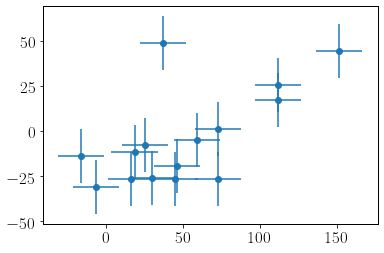

In [12]:
plt.errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o')
plt.show()